# Relevant Imports

In [17]:
import numpy as np
import pandas as pd
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit, train_test_split

from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertModel
from transformers import AutoConfig
from transformers import Trainer, TrainingArguments

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

# Ignore all warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

In [2]:
filepath = '../../../../dataset_final/FinSen_S&P500/multimodal_S&P500_all.csv'
data = pd.read_csv(filepath)
data.head()

,Unnamed: 0,Date,Open,Movement,sentiment_volatility_lag1,aggregate_sentiment_score_lag1,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1,garch_cond_variance_lag1,garch_cond_volatility_lag1,garch_residuals_lag1,rolling_cond_volatility_3_lag1,rolling_cond_volatility_5_lag1,Title,cleaned_content
0,0,2007-08-01,1455.18,0,0.268142,0.00,1455.27,1488.30,4.524520e+09,-0.251552,0.991957,NaN,NaN,NaN,NaN,NaN,U.S. Companies added the smallest number of jo...,U.S. Companies added the smallest number of jo...
1,1,2007-08-07,1467.61,1,0.270222,-0.15,1465.81,1468.38,5.256780e+09,0.724264,1.257202,1.440581,1.200242,0.721654,NaN,NaN,US Federal Reserve keeps interest rates unchan...,US Federal Reserve keeps interest rates unchan...
2,2,2007-08-10,1453.08,0,0.262336,0.00,1476.70,1488.30,4.909390e+09,0.742934,1.384401,1.311621,1.145260,0.740188,NaN,NaN,Stock Markets Fall Worldwide! Recession?,Stock Markets Fall Worldwide! Recession?United...
3,3,2007-08-13,1453.42,0,0.367736,-0.67,1453.64,1462.02,5.345780e+09,-1.561590,1.159805,1.517074,1.231695,-1.573911,1.423092,NaN,Goldman Sachs fights back by putting $3 billio...,Goldman Sachs fights back by putting $3 billio...
4,4,2007-08-14,1452.86,0,0.275372,-0.20,1452.92,1466.29,3.696280e+09,-0.049531,0.942009,1.286727,1.134340,-0.049543,1.371807,NaN,U.S. Trade Deficit Narrows in June to $58.1 Bln,U.S. Trade Deficit Narrows in June to $58.1 Bl...


In [3]:
if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])
data.head()

,Date,Open,Movement,sentiment_volatility_lag1,aggregate_sentiment_score_lag1,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1,garch_cond_variance_lag1,garch_cond_volatility_lag1,garch_residuals_lag1,rolling_cond_volatility_3_lag1,rolling_cond_volatility_5_lag1,Title,cleaned_content
0,2007-08-01,1455.18,0,0.268142,0.00,1455.27,1488.30,4.524520e+09,-0.251552,0.991957,NaN,NaN,NaN,NaN,NaN,U.S. Companies added the smallest number of jo...,U.S. Companies added the smallest number of jo...
1,2007-08-07,1467.61,1,0.270222,-0.15,1465.81,1468.38,5.256780e+09,0.724264,1.257202,1.440581,1.200242,0.721654,NaN,NaN,US Federal Reserve keeps interest rates unchan...,US Federal Reserve keeps interest rates unchan...
2,2007-08-10,1453.08,0,0.262336,0.00,1476.70,1488.30,4.909390e+09,0.742934,1.384401,1.311621,1.145260,0.740188,NaN,NaN,Stock Markets Fall Worldwide! Recession?,Stock Markets Fall Worldwide! Recession?United...
3,2007-08-13,1453.42,0,0.367736,-0.67,1453.64,1462.02,5.345780e+09,-1.561590,1.159805,1.517074,1.231695,-1.573911,1.423092,NaN,Goldman Sachs fights back by putting $3 billio...,Goldman Sachs fights back by putting $3 billio...
4,2007-08-14,1452.86,0,0.275372,-0.20,1452.92,1466.29,3.696280e+09,-0.049531,0.942009,1.286727,1.134340,-0.049543,1.371807,NaN,U.S. Trade Deficit Narrows in June to $58.1 Bln,U.S. Trade Deficit Narrows in June to $58.1 Bl...


In [4]:
'''# Suppose your DataFrame is called df and it has a column named 'combined_text'
data['cleaned_content'] = data['combined_text'].shift(1)
data.head()'''

"# Suppose your DataFrame is called df and it has a column named 'combined_text'\ndata['cleaned_content'] = data['combined_text'].shift(1)\ndata.head()"

In [5]:
data.columns

Index(['Date', 'Open', 'Movement', 'sentiment_volatility_lag1',
       'aggregate_sentiment_score_lag1', 'Close_lag1', 'High_lag1',
       'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1',
       'garch_cond_variance_lag1', 'garch_cond_volatility_lag1',
       'garch_residuals_lag1', 'rolling_cond_volatility_3_lag1',
       'rolling_cond_volatility_5_lag1', 'Title', 'cleaned_content'],
      dtype='object')

In [6]:
# Handling missing values in rolling features
rolling_features = [
    'garch_cond_variance_lag1', 
    'garch_cond_volatility_lag1',
       'garch_residuals_lag1', 
    'rolling_cond_volatility_3_lag1',
       'rolling_cond_volatility_5_lag1'
]  # Add any other rolling features here

# Check for missing values
print(data[rolling_features].isnull().sum())

# Drop rows with missing values
data = data.dropna(subset=rolling_features).reset_index(drop=True)


garch_cond_variance_lag1          1
garch_cond_volatility_lag1        1
garch_residuals_lag1              1
rolling_cond_volatility_3_lag1    3
rolling_cond_volatility_5_lag1    5
dtype: int64


In [7]:
data.head()

,Date,Open,Movement,sentiment_volatility_lag1,aggregate_sentiment_score_lag1,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1,garch_cond_variance_lag1,garch_cond_volatility_lag1,garch_residuals_lag1,rolling_cond_volatility_3_lag1,rolling_cond_volatility_5_lag1,Title,cleaned_content
0,2007-08-15,1426.15,0,0.250898,-0.23,1426.54,1456.73,3.814630e+09,-1.815654,1.229445,1.638952,1.280215,-1.832339,1.480917,1.438991,U.S. Consumer Prices Rise Less Than Expected,U.S. Consumer Prices Rise Less Than ExpectedUn...
1,2007-08-16,1406.64,0,0.256807,-0.10,1406.69,1440.78,4.290930e+09,-1.391479,1.107264,1.705249,1.305852,-1.401251,1.543642,1.491924,Dow Jones recovers 300 points in the final 45 ...,Dow Jones recovers 300 points in the final 45 ...
2,2007-08-17,1411.26,0,0.259172,0.01,1411.27,1415.96,6.509300e+09,0.325587,0.967345,1.459424,1.208066,0.325058,1.601208,1.521485,Federal Reserve cuts interest rates by 50 bps,Federal Reserve cuts interest rates by 50 bpsU...
3,2007-08-20,1445.93,0,0.110589,0.00,1445.93,1450.32,3.570040e+09,2.455944,1.682839,2.191603,1.480406,2.426270,1.785425,1.656391,Stocks rise as subprime concerns ease,Stocks rise as subprime concerns easeUnited St...
4,2007-08-28,1466.71,1,0.097622,-0.05,1445.55,1451.75,3.321340e+09,-0.026281,1.683028,1.845594,1.358527,-0.026284,1.832207,1.768165,Americans' Confidence Weakens by Most in Two Y...,Americans' Confidence Weakens by Most in Two Y...


In [8]:
data.value_counts

<bound method DataFrame.value_counts of              Date     Open  Movement  sentiment_volatility_lag1  \
0      2007-08-15  1426.15         0                   0.250898   
1      2007-08-16  1406.64         0                   0.256807   
2      2007-08-17  1411.26         0                   0.259172   
3      2007-08-20  1445.93         0                   0.110589   
4      2007-08-28  1466.71         1                   0.097622   
...           ...      ...       ...                        ...   
15225  2023-07-14  4514.60         1                   0.504529   
15226  2023-07-14  4514.60         1                   0.504529   
15227  2023-07-14  4514.60         1                   0.504529   
15228  2023-07-14  4514.60         1                   0.504529   
15229  2023-07-14  4514.60         1                   0.504529   

       aggregate_sentiment_score_lag1  Close_lag1  High_lag1   Volume_lag1  \
0                               -0.23     1426.54    1456.73  3.814630e+09   

# Generate embeddings

## a. Textual Embeddings

In [9]:
# ----------------------------
# Set device: use Apple MPS if available, otherwise CPU
# ----------------------------
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using device:", device)

# ----------------------------
# Load FinBERT model and tokenizer
# ----------------------------
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.to(device)
model.eval()

def get_embedding(text):
    """
    Generate an embedding for the input text using FinBERT on the specified device.
    Returns the CLS token embedding as the sentence representation.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    # Move inputs to the device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, hidden_size)
    # Move embedding back to CPU before converting to numpy
    return cls_embedding.squeeze(0).cpu().numpy()

# ----------------------------
# Load and sort the dataset
# ----------------------------
df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])

# ----------------------------
# Iterate over all unique dates to compute aggregated embedding
# using the last available date (with articles) in the dataset
# ----------------------------
unique_dates = np.sort(df['Date'].unique())
prev_date_embeddings = {}

for current_date in unique_dates:
    # Get all dates strictly less than the current_date
    available_dates = df[df['Date'] < current_date]['Date']
    if available_dates.empty:
        print(f"No previous date available for {pd.Timestamp(current_date).date()}. Using zero vector.")
        embedding = np.zeros(768)
    else:
        # Use the last available date prior to current_date
        last_available_date = available_dates.max()
        print(f"For current date {pd.Timestamp(current_date).date()}, last available date is {pd.Timestamp(last_available_date).date()}")
        
        # Retrieve articles for that date
        articles = df[df['Date'] == last_available_date]['cleaned_content']
        if articles.empty:
            print(f"No articles found for date {pd.Timestamp(last_available_date).date()}, using zero vector.")
            embedding = np.zeros(768)
        else:
            embeddings = [get_embedding(article) for article in articles]
            embedding = np.mean(embeddings, axis=0)
    prev_date_embeddings[current_date] = embedding

# Map the computed embeddings back to the DataFrame
df['prev_day_embedding'] = df['Date'].map(prev_date_embeddings)

# Debug print: check the embedding shape for the first row
print("First row aggregated previous date embedding shape:", df.iloc[0]['prev_day_embedding'].shape)


Using device: mps
No previous date available for 2007-08-15. Using zero vector.
For current date 2007-08-16, last available date is 2007-08-15
For current date 2007-08-17, last available date is 2007-08-16
For current date 2007-08-20, last available date is 2007-08-17
For current date 2007-08-28, last available date is 2007-08-20
For current date 2007-08-29, last available date is 2007-08-28
For current date 2007-08-30, last available date is 2007-08-29
For current date 2007-08-31, last available date is 2007-08-30
For current date 2007-09-04, last available date is 2007-08-31
For current date 2007-09-07, last available date is 2007-09-04
For current date 2007-09-10, last available date is 2007-09-07
For current date 2007-09-11, last available date is 2007-09-10
For current date 2007-09-12, last available date is 2007-09-11
For current date 2007-09-17, last available date is 2007-09-12
For current date 2007-09-18, last available date is 2007-09-17
For current date 2007-09-19, last avai

## b. Numerical Embeddings

In [10]:
# Define the numerical columns
numerical_cols = ['Open','sentiment_volatility_lag1',
       'aggregate_sentiment_score_lag1', 'Close_lag1', 'High_lag1',
       'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1',
       'garch_cond_variance_lag1', 'garch_cond_volatility_lag1',
       'garch_residuals_lag1', 'rolling_cond_volatility_3_lag1',
       'rolling_cond_volatility_5_lag1' ]

# ----------------------------
# Scale the numerical features
# ----------------------------
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# ----------------------------
# Now, create the combined market vector for each row
# ----------------------------
def create_market_vector(row):
    """
    Extracts the scaled numerical features and the previous day's aggregated embedding,
    then concatenates them to form the final market vector.
    """
    # Get the scaled numerical features as a numpy array
    num_features = row[numerical_cols].to_numpy(dtype=np.float64)
    text_embedding = row['prev_day_embedding']  # Should be a numpy array of shape (768,)
    # Concatenate the numerical features and the text embedding
    market_vector = np.concatenate([num_features, text_embedding])
    return market_vector

df['market_vector'] = df.apply(create_market_vector, axis=1)

# Debug print: check the shape of the market vector for the first row
print("Market vector shape for the first row:", df.iloc[0]['market_vector'].shape)


Market vector shape for the first row: (781,)


In [11]:
df['prev_day_embedding'].head(10)

0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.79990417, -0.85835904, 0.67363983, 0.494398...
2    [-0.119094044, -0.5147009, 0.4948414, -0.02991...
3    [0.20119804, -0.6456618, -0.6850371, -0.383465...
4    [0.44803962, -0.71044713, 0.85101926, -0.01981...
5    [0.44803962, -0.71044713, 0.85101926, -0.01981...
6    [-0.25896275, -0.23763445, 0.45601386, -0.5563...
7    [0.7618173, -0.9638824, 0.17917246, 0.34075466...
8    [1.0570505, -0.6290452, 0.5072711, -0.23210202...
9    [-0.1619807, -0.59626406, -0.37136692, -0.1494...
Name: prev_day_embedding, dtype: object

## Cosine similarity between embeddings

In [12]:
# ----------------------------
# Assume 'df' already contains:
# - Scaled numerical features in columns defined by `numerical_cols`
# - The aggregated textual embedding in the column 'prev_day_embedding' (each is 768-dim)
# ----------------------------

df1 = df.copy()

# 1. Extract all aggregated textual embeddings into a matrix (n_samples x 768)
# Note: Ensure that all embeddings are in a consistent shape.
text_embeddings = np.stack(df1['prev_day_embedding'].values)  # shape: (n_samples, 768)

# 2. Reduce textual embeddings to 13 dimensions using PCA for comparison
pca = PCA(n_components=13)
text_embeddings_reduced = pca.fit_transform(text_embeddings)  # shape: (n_samples, 14)

# 3. For each day, compute cosine similarity between the numerical features and the reduced textual embedding.
similarities = []
for i, row in df1.iterrows():
    # Extract the scaled numerical features (14-dimensional)
    num_features = row[numerical_cols].to_numpy(dtype=np.float64).reshape(1, -1)  # shape: (1, 14)
    
    # Get the corresponding reduced textual embedding (14-dimensional)
    text_emb = text_embeddings_reduced[i].reshape(1, -1)  # shape: (1, 14)
    
    # Compute cosine similarity between these two 14-dim vectors
    sim = cosine_similarity(num_features, text_emb)[0, 0]
    similarities.append(sim)

# 4. Save and inspect the similarity scores
df1['num_text_similarity'] = similarities

# Debug print: Summary statistics for the cosine similarity across days
print("Cosine similarity between numerical and (PCA-reduced) textual embeddings per day:")
print(df1['num_text_similarity'].describe())


Cosine similarity between numerical and (PCA-reduced) textual embeddings per day:
count    15230.000000
mean        -0.065897
std          0.353583
min         -0.868955
25%         -0.353766
50%         -0.096636
75%          0.207529
max          0.858292
Name: num_text_similarity, dtype: float64


# Downstream Classification Model

## Logistic Regression 

### **RandomSplit** - Data split randomly using 80/20 train test split.

In [13]:
# Stack the market vectors into a 2D array 
X = np.stack(df['market_vector'].values)
y = df['Movement'].values  # Ensure these are 0 and 1

In [14]:
# Initialize TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)

# Initialize lists to store train and test dates
train_dates_list = []
test_dates_list = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Instead of X.index, use the DataFrame's 'Date' column to map indices back to dates
    train_dates = df.loc[train_index, 'Date']
    test_dates = df.loc[test_index, 'Date']
    
    # Store the dates
    train_dates_list.append(train_dates)
    test_dates_list.append(test_dates)
    
    # Print the date range for each fold (optional)
    print(f"Fold {fold + 1}:")
    print(f"Train Dates: {train_dates.min().strftime('%Y-%m-%d')} to {train_dates.max().strftime('%Y-%m-%d')}")
    print(f"Test Dates: {test_dates.min().strftime('%Y-%m-%d')} to {test_dates.max().strftime('%Y-%m-%d')}")
    print("-" * 50)


Fold 1:
Train Dates: 2007-08-15 to 2016-10-17
Test Dates: 2016-10-17 to 2018-08-15
--------------------------------------------------
Fold 2:
Train Dates: 2007-08-15 to 2018-08-15
Test Dates: 2018-08-15 to 2020-08-19
--------------------------------------------------
Fold 3:
Train Dates: 2007-08-15 to 2020-08-19
Test Dates: 2020-08-19 to 2021-10-11
--------------------------------------------------
Fold 4:
Train Dates: 2007-08-15 to 2021-10-11
Test Dates: 2021-10-11 to 2022-08-04
--------------------------------------------------
Fold 5:
Train Dates: 2007-08-15 to 2022-08-04
Test Dates: 2022-08-04 to 2023-07-14
--------------------------------------------------


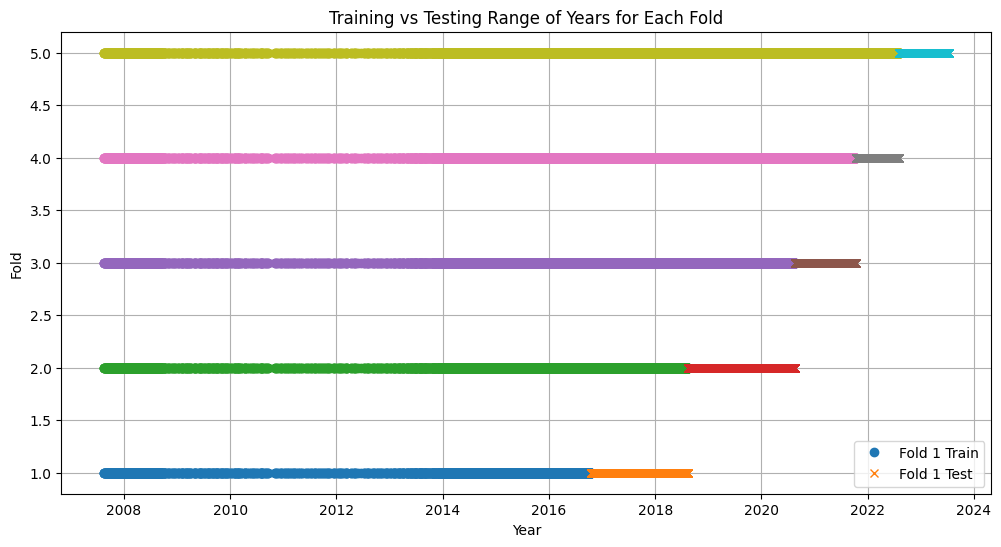

In [15]:
# Plot training vs testing years
plt.figure(figsize=(12, 6))

for i, (train, test) in enumerate(zip(train_dates_list, test_dates_list)):
    plt.plot(train, [i + 1] * len(train), 'o', label=f'Fold {i + 1} Train' if i == 0 else "")
    plt.plot(test, [i + 1] * len(test), 'x', label=f'Fold {i + 1} Test' if i == 0 else "")

plt.xlabel('Year')
plt.ylabel('Fold')
plt.title('Training vs Testing Range of Years for Each Fold')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('training_vs_testing_years.png')
plt.show()


Confusion Matrix:
[[1046  307]
 [ 277 1416]]


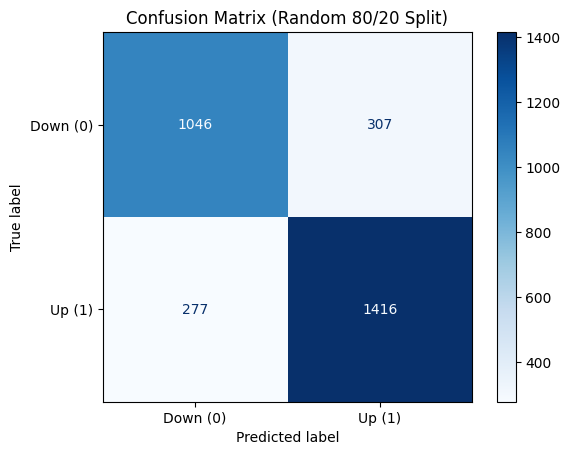

Accuracy: 0.81
Precision: 0.82
Recall: 0.84
F1-Score: 0.83
ROC-AUC: 0.87


In [18]:
# Assume X and y are defined as NumPy arrays:
# X: shape (n_samples, 782)
# y: shape (n_samples,) with binary values 0 and 1.

# Perform a random train-test split: 80% training, 20% test.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Print and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
disp.plot(cmap="Blues")
disp.ax_.set_title("Confusion Matrix (Random 80/20 Split)")
plt.savefig('confusion_matrix_random_split.png')
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")
